In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### play game func

In [12]:
import numpy as np
import torch
from agent import Agent
from board import Board
from model import ConnectFourNN

def play_exp_game(agent1:Agent, agent2:Agent, type = 'greedy', eps = 0):
    """
    # Returns:
    list of experience from the game from both players
    """

    board = Board()
    agent1.board = board
    agent2.board = board
    curr_agent = agent2
    done = False

    states = []
    actions = []
    rewards = []
    dones = []

    while not done:
        curr_agent = agent1 if curr_agent != agent1 else agent2

        state = curr_agent.get_board_state()
        action = curr_agent.choose_action(state, type='greedy', eps=eps)
        reward = curr_agent.perform_action(action)
        
        # update previous player if he lost or drew
        if reward == Board.rewards_dict['win']:
            rewards[-1] = Board.rewards_dict['loss']
            dones[-1] = True
        elif reward == Board.rewards_dict['draw']:
            rewards[-1] = Board.rewards_dict['draw']
            dones[-1] = True

        actions.append(action)
        rewards.append(reward)
        states.append(state)
        dones.append(reward != 0)

        done = dones[-1]
    
    # minus is there because its the other guys' perspective
    states.append(-state)
    states.append(state)

    exp_list = []
    for i in range(len(rewards)):
        # next state is added with offset=2
        exp_list.append((states[i], actions[i], rewards[i], states[i+2], dones[i]))

    return exp_list

In [13]:
def play_eval_game(main_agent:Agent, num_games = 100) -> int:
    """
    # Returns:
    total reward gained divided by `num_games`. It's from range [`-1`, `1`]
    """
    
    board = Board()
    test_agent = Agent(main_model = ConnectFourNN(), piece_tag = 1 if main_agent.piece_tag == 2 else 2, device = device, board = board)
    main_agent.board = board
    curr_agent = test_agent

    total_reward = 0
    for _ in range(num_games):
        done = False
        board.reset_board()
        
        while not done:
            curr_agent = main_agent if curr_agent != main_agent else test_agent
            eps = 0 if curr_agent == main_agent else 1

            state = curr_agent.get_board_state()
            action = curr_agent.choose_action(state, type='greedy', eps = eps)
            reward = curr_agent.perform_action(action)

            done = (reward != 0)
        
        if reward == Board.rewards_dict['win']:
            total_reward += 1 if curr_agent == main_agent else -1
    
    return total_reward / num_games

In [14]:
def get_max_qval(model, states:np.ndarray|None = None, actions = (2, 2, 2), device='cpu'):
    """
    For a list of `states`, return best q_values estimated by the `model` 
    """

    if states is None:
        states = np.array([
            np.array([
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
            ], dtype=np.int8),
            np.array([
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0],
                [0, 0, 1, -1, 0, 0, 0],
                [0, 0, 1, -1, -1, 0, 0],
            ], dtype=np.int8),
            np.array([
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 0, 0, 0],
                [1, 0, -1, -1, -1, 0, 0],
            ], dtype=np.int8)
            ])

    states_tensor = torch.tensor(states, dtype=torch.float32).unsqueeze(1).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)

    with torch.no_grad():
        q_values = model(states_tensor).gather(1, actions).cpu().numpy()

    return q_values

### Train step func

In [15]:
import torch.nn as nn

def train_step(main_model:nn.Module, target_model:nn.Module, optimizer, replay_buffer, gamma, batch_size, loss_class, device):
    if len(replay_buffer) < batch_size:
        return 0
    
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(main_model.parameters(), max_norm=1.0)

    main_model.train()

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    # equal_flags = [np.array_equal(states[i], next_states[i]) for i in range(len(states))]

    states = torch.tensor(np.array(states), dtype=torch.float32).unsqueeze(1).to(device)
    actions = torch.tensor(np.array(actions), dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).unsqueeze(1).to(device)
    dones = torch.tensor(np.array(dones), dtype=torch.int8).to(device)

    q_values = main_model(states).gather(1, actions).squeeze()

    next_q_values = target_model(next_states).max(1)[0]
    target_q_values = rewards + gamma * next_q_values * (1-dones)

    loss = loss_class(q_values, target_q_values.detach())

    loss.backward()
    optimizer.step()

    return loss.detach().cpu().numpy()

# Hyper Parameters

In [16]:
import torch.nn as nn

# TODO fine tune
eps = 1
eps_min = 0.1
eps_decay = 0.99995
epochs = 10**5
batch_size = 64*2
train_freq = 1
target_update_freq = 50
eval_freq = 10
checkpoint_freq = epochs // 10
gamma = 0.99
lr = 1e-6

# TODO TEST OTHER
# loss_class = nn.MSELoss()
loss_class = nn.HuberLoss()


# Initialize Models

In [17]:
import torch
from model import ConnectFourNN
from replay_buffer import ReplayBuffer
import torch.optim as optim

def initialize_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

main_model = ConnectFourNN().to(device)
main_model.apply(initialize_weights_he)

target_model = ConnectFourNN().to(device)
target_model.load_state_dict(main_model.state_dict())
target_model.eval()

replay_buffer = ReplayBuffer()

optimizer = optim.Adam(main_model.parameters(), lr = lr)

agent1 = Agent(main_model, piece_tag=1, device=device)
agent2 = Agent(main_model, piece_tag=2, device=device)

# Training Loop

  0%|          | 0/100000 [00:00<?, ?it/s]

 10%|▉         | 9999/100000 [05:15<54:57, 27.29it/s]  

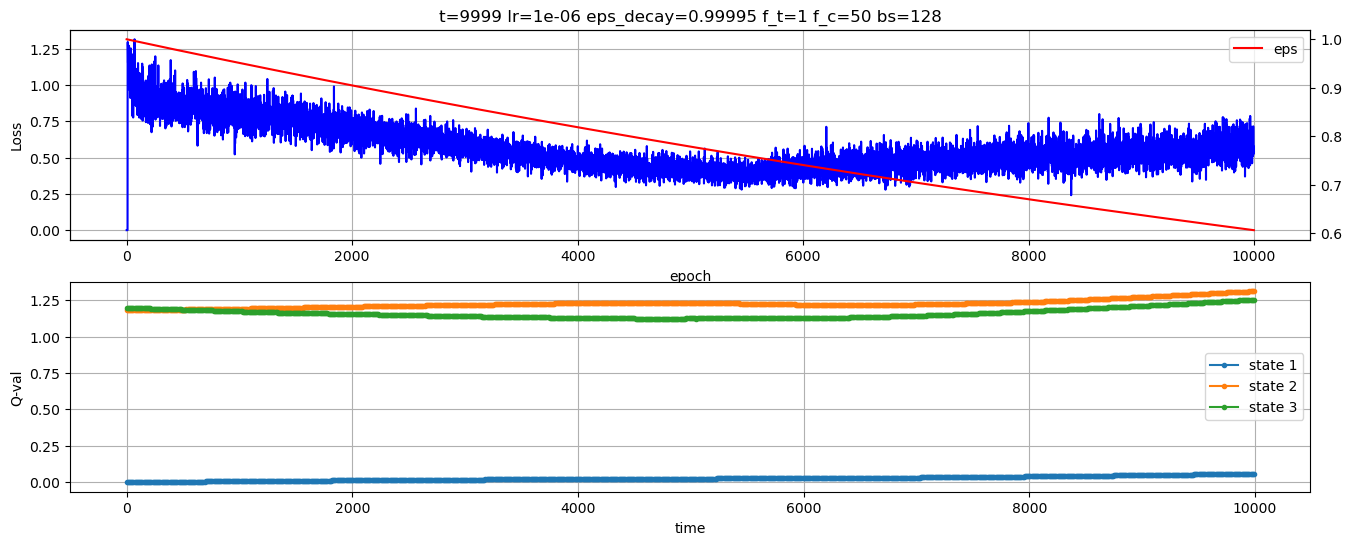

 20%|█▉        | 19998/100000 [13:45<52:36, 25.34it/s]   

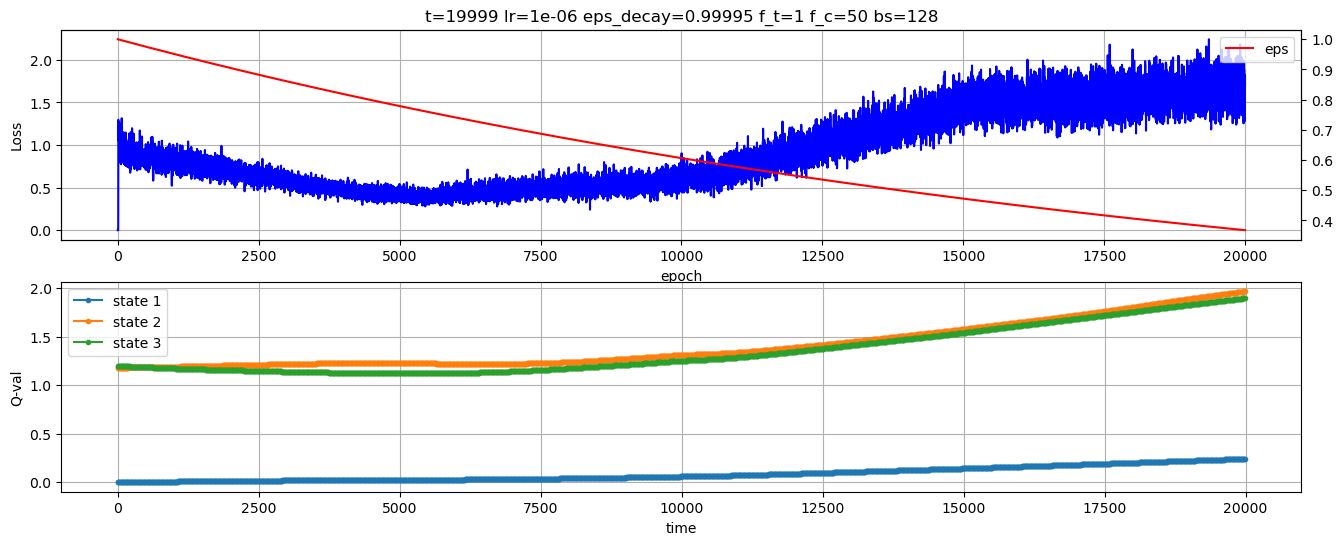

 30%|██▉       | 29998/100000 [18:57<28:12, 41.36it/s]  

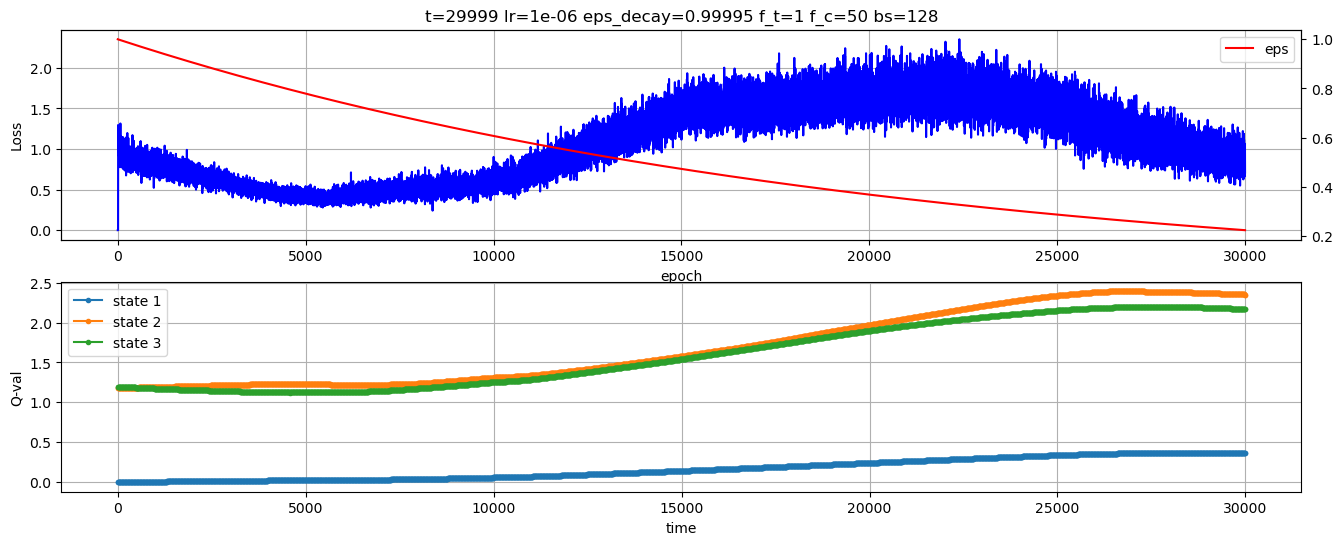

 40%|███▉      | 39999/100000 [23:59<55:24, 18.05it/s]  

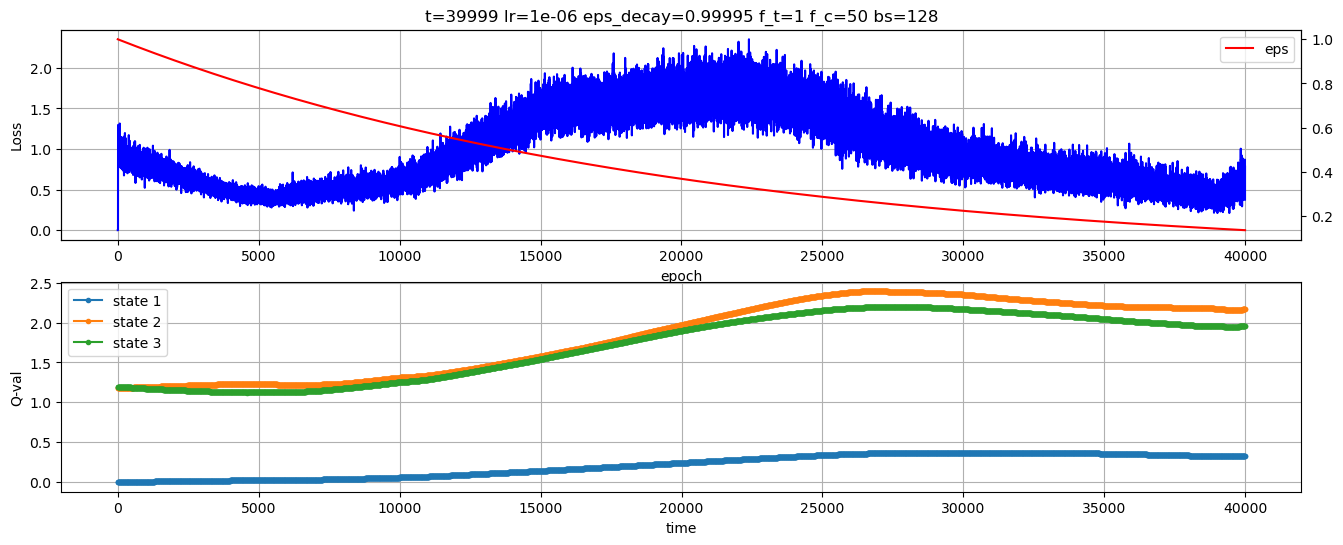

 50%|████▉     | 49996/100000 [28:25<16:03, 51.91it/s]  

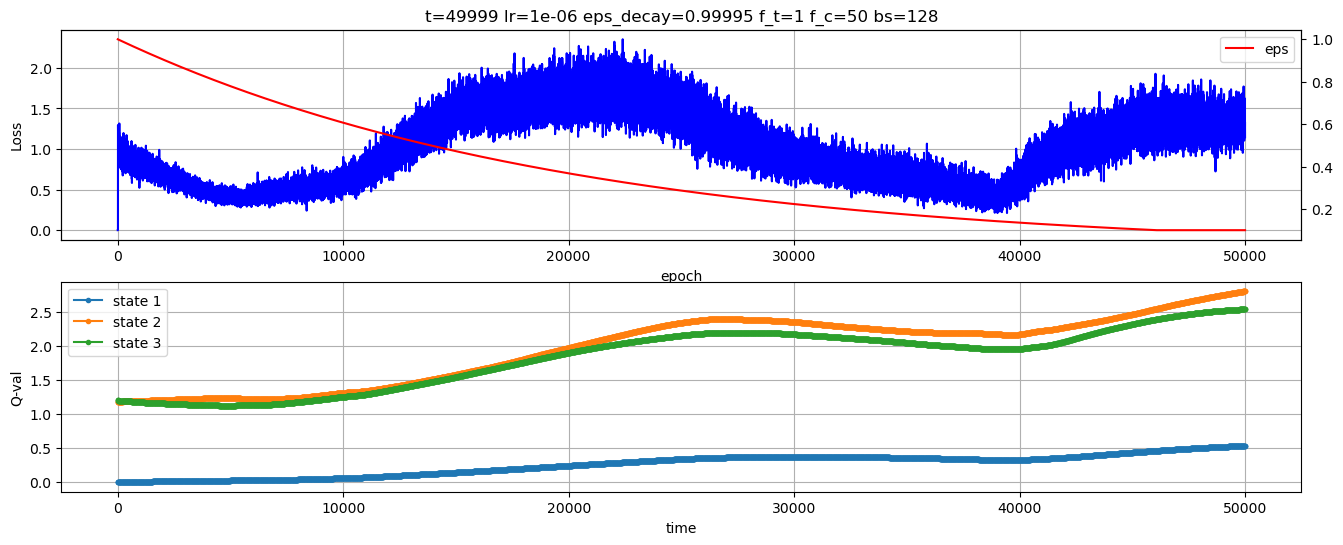

 60%|█████▉    | 59997/100000 [46:58<30:42, 21.71it/s]    

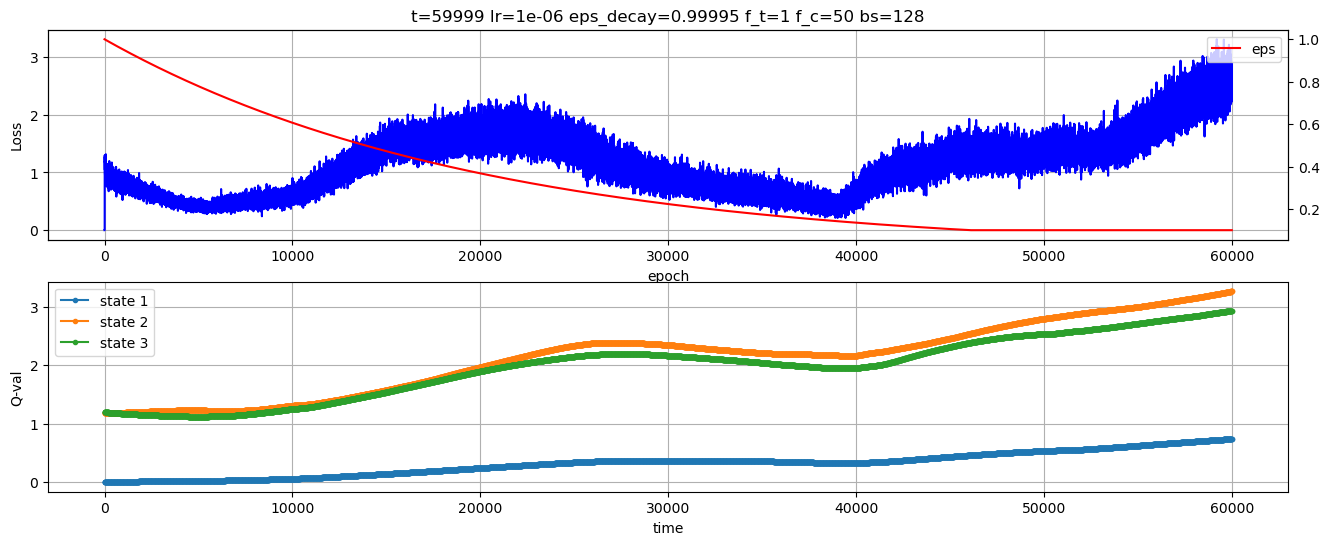

 70%|██████▉   | 69999/100000 [52:56<20:15, 24.68it/s]  

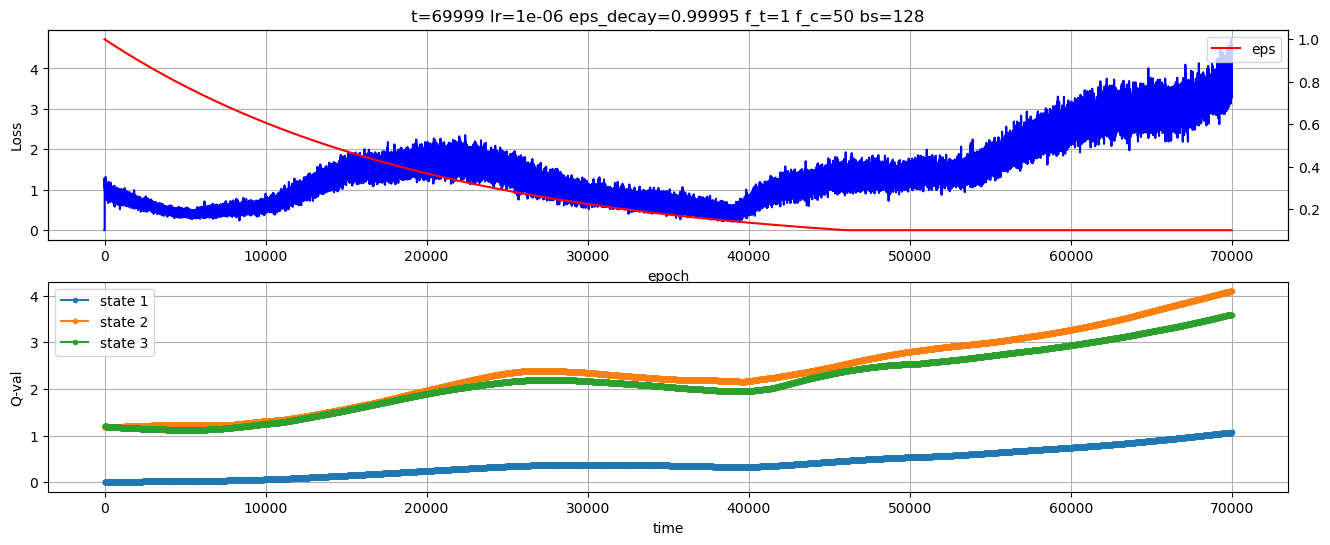

 80%|███████▉  | 79999/100000 [1:00:31<11:00, 30.30it/s]

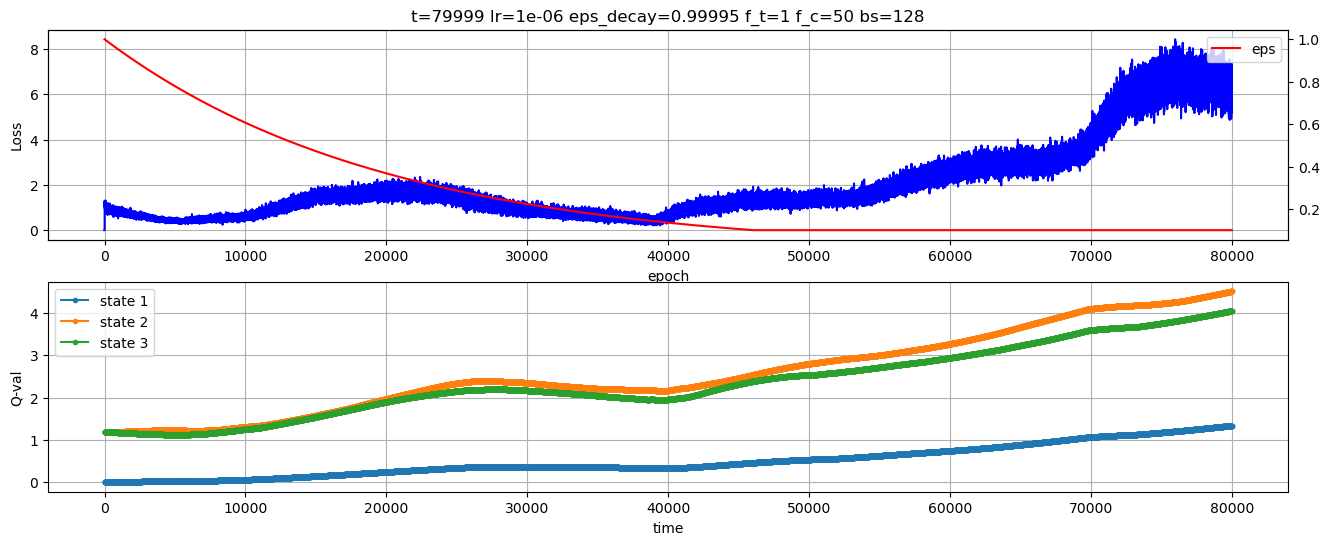

 90%|████████▉ | 89999/100000 [1:06:32<06:57, 23.97it/s]

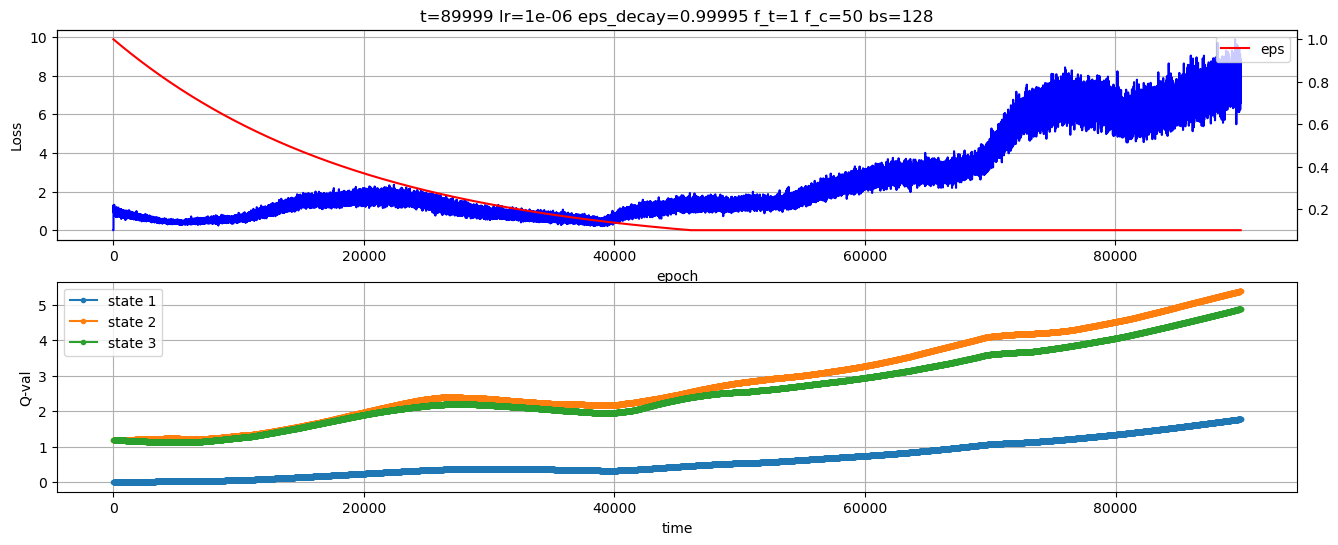

100%|█████████▉| 99998/100000 [1:14:03<00:00, 21.88it/s]

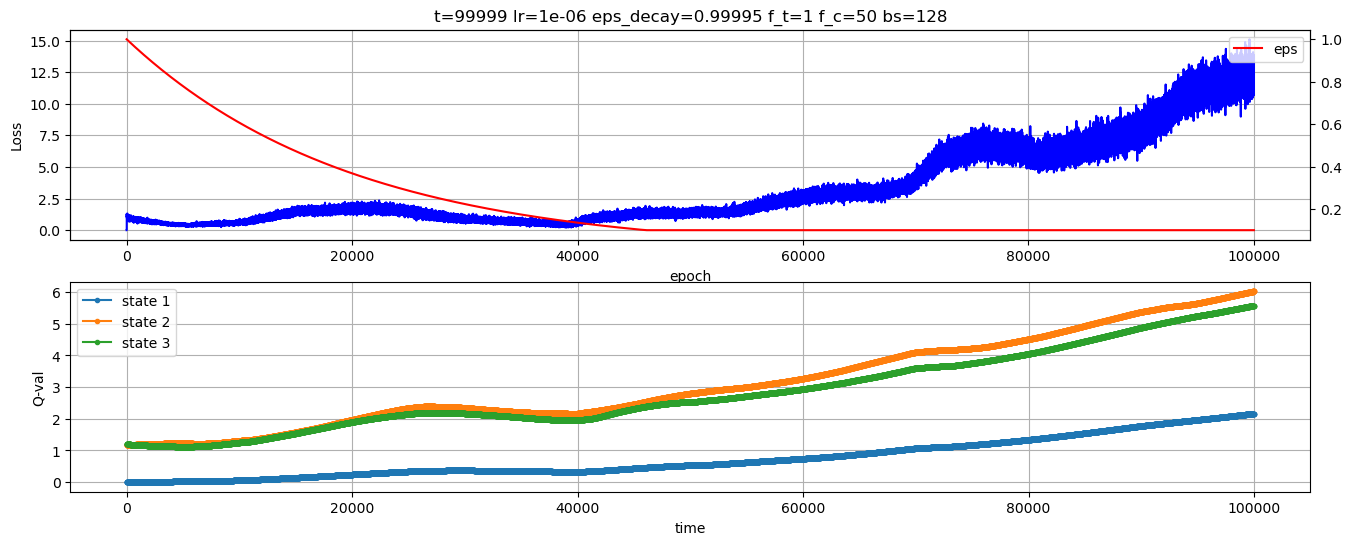

100%|██████████| 100000/100000 [1:14:05<00:00, 22.50it/s]


In [18]:
from datetime import datetime
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

losses = []
times = []
EPS = []
results = []
eval_times = []
eval_scores1 = [], []
eval_qval1 = []
eval_qval2  = []
eval_qval3 = []

for t in tqdm(range(epochs)):
    exp_list = play_exp_game(agent1, agent2, eps)
    replay_buffer.extend(exp_list)

    if not t % train_freq:
        loss = train_step(main_model, target_model, optimizer, replay_buffer, gamma, batch_size, loss_class, device)
        times.append(t)
        losses.append(loss)
        EPS.append(eps)

    if not t % target_update_freq:
        target_model.load_state_dict(main_model.state_dict())

    if not t % eval_freq:
        eval_times.append(t)
        # eval_scores1.append(play_eval_game(agent1, num_games=20))
        q_val = get_max_qval(main_model, device=device)
        eval_qval1.append(q_val[0])
        eval_qval2.append(q_val[1])
        eval_qval3.append(q_val[2])
                
    if not (t+1) % checkpoint_freq:
        stamp = datetime.now().strftime("%d%m%y-%H%M%S")
        path = rf'models/cp{t//checkpoint_freq}_{stamp}.pth'
        torch.save(main_model, path)

        plt.figure(figsize=(16, 6))
        plt.subplot(211)
        plt.plot(times, losses, 'b-')
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.grid()
        ax2 = plt.twinx()
        ax2.plot(times, EPS, 'r-', label='eps')
        ax2.legend()
        plt.title(f't={t} lr={lr:.0e} eps_decay={eps_decay} f_t={train_freq} f_c={target_update_freq} bs={batch_size}')

        plt.subplot(212)
        plt.plot(eval_times, eval_qval1, 'o-', markersize=3, label=f'state 1')
        plt.plot(eval_times, eval_qval2, 'o-', markersize=3, label=f'state 2')
        plt.plot(eval_times, eval_qval3, 'o-', markersize=3, label=f'state 3')
        plt.xlabel('time')
        plt.ylabel('Q-val')
        plt.legend()
        plt.grid()
        plt.show()

    if eps > eps_min:
        eps *= eps_decay

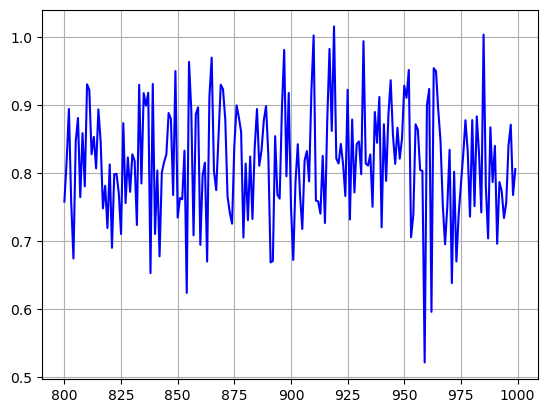

In [19]:
plt.plot(times[800:1000], losses[800:1000], 'b-')
plt.grid()

In [20]:
main_model.state_dict()['fc1.weight'][4]

tensor([ 0.0033, -0.0250,  0.1307, -0.0735, -0.0872,  0.0109, -0.1440, -0.3646,
        -0.2587, -0.1622, -0.1833, -0.2048,  0.0077, -0.0240,  0.2775, -0.1327,
        -0.1277,  0.2372,  0.0693, -0.0122,  0.1365, -0.1122, -0.2419, -0.1006,
         0.1881, -0.1591,  0.3023,  0.0940,  0.2198,  0.2965,  0.0554,  0.0241,
         0.0977,  0.1323,  0.2307,  0.0650,  0.0706,  0.3355,  0.0278, -0.3251,
        -0.1342, -0.1169])

In [21]:
replay_buffer.sample(1)

[(array([[ 1,  0,  0, -1, -1, -1,  0],
         [-1,  0,  0,  1,  1,  1,  0],
         [ 1,  0,  0, -1, -1, -1,  0],
         [-1,  0,  0,  1,  1,  1,  0],
         [ 1,  0,  0, -1, -1, -1,  0],
         [-1,  0,  0,  1,  1,  1,  0]], dtype=int8),
  2,
  1,
  array([[ 1,  0,  0, -1, -1, -1,  0],
         [-1,  0,  0,  1,  1,  1,  0],
         [ 1,  0,  0, -1, -1, -1,  0],
         [-1,  0,  0,  1,  1,  1,  0],
         [ 1,  0,  0, -1, -1, -1,  0],
         [-1,  0,  0,  1,  1,  1,  0]], dtype=int8),
  True)]

In [22]:
with torch.no_grad():
    q_val = main_model(torch.tensor(np.array([
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 0, 0, 0],
                [1, 0, -1, -1, -1, 0, 0],
            ], dtype=np.float32).reshape(1, 1, 6, 7)))
dones = torch.tensor(np.array([False, True, True]), dtype=torch.int8).to(device)

q_val.max(1)[0]*(1-dones)

tensor([19.5713,  0.0000,  0.0000])

In [23]:

1-dones

tensor([1, 0, 0], dtype=torch.int8)